## Bayesian Neural Networks
This notebook is a PyTorch implementation of a one-layer Bayesian Neural Network using Gaussian Prior on weights with known mean and variance and an unknown Gaussian variational posterior. It is based on [this](https://davidstutz.de/a-short-introduction-to-bayesian-neural-networks/) excellent short tutorial on Bayesian Neural Networks. This implementation deals with two scenarios: 

1. Closed-form KL Divergence exists
2. Closed-form KL Divergence doesn't exist -- Bayes by Backprop

In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import numpy as np
import scipy
import skimage
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io as skio
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math

Set the configuration variables

In [2]:
batchsize = 4
prior_mu = torch.tensor([0]).float()
prior_sigma = torch.tensor([1]).float()
in_features = int(28*28)
out_features = 10
numEpochs = 5
numWorkers = 2
closed_form  = True #Set false to use Bayes by Backprop

Set dataloader

In [3]:

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))
                       ])),
        batch_size=batchsize, shuffle=True, num_workers=numWorkers)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))
    ])),
    batch_size=batchsize, shuffle=False, num_workers=numWorkers)

N = int(len(train_loader)*batchsize)

## Reparametrization Trick
Reparametrization trick for Variational Inference similar to VAE [[Link]](https://arxiv.org/abs/1312.6114). Helps with backpropagation through a sampling process.

In [4]:
def reparametrize(mu, sigma, sampling=True):
    var = sigma**2
    if sampling:
        std = torch.sqrt(var)
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return mu + eps * std
    else:
        return mu #if not sampling, then return the variational posterior mean

In [5]:
def computelogPrior(wt):
    """
    Computes the prior probability for the weights. 
    Needs to be changed based on the prior form.
    """
    norm_factor = torch.log(1/(torch.sqrt(torch.tensor([2*3.1416]))*prior_sigma))
    exp_factor = torch.log(torch.exp(-(1/2)*(((wt-prior_mu)/prior_sigma)**2)))
    logprob = norm_factor + exp_factor
    return logprob

In [6]:
def computelogVarPost(wt,post_mu,post_sigma):
    """
    Computes the posterior probability for the weights. 
    Needs to be changed based on the prior form.
    """
    post_var = post_sigma**2
    norm_factor = torch.log(1/torch.sqrt(2*3.1416*post_var))
    exp_factor = torch.log(torch.exp(-(1/2)*(((wt-post_mu)/torch.sqrt(post_var))**2)))
    logpost = norm_factor + exp_factor
    return logpost

Define the network

In [7]:
#One layer Bayesian Neural Network
class LinearGaussian(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearGaussian, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.post_mu = nn.Parameter(torch.zeros((out_features,in_features))+0.8)
        self.post_sigma = nn.Parameter(torch.zeros((out_features,in_features))+1.1)
        self.sampling = True
    def forward(self,x):
        x = x.view(-1,self.in_features)
        self.wts = reparametrize(self.post_mu,self.post_sigma,self.sampling)
        y = F.linear(x,self.wts,bias=None)
        return y  


## KL-Divergence
For flag *closed_form=True*, we need to calculate the KL-Divergence between the gaussian prior and gaussian variational posterior. Refer to this paper for the derivation [[Link]](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks).<br><br>
$KL(q_{\phi}(\textbf{w})|p(\textbf{w})) = \sum_{i=1}^{W}{ln(\frac{\sigma_{prior}}{\sigma_i}}) + \frac{1}{\sigma_{prior}^{2}}[(\mu_i - \mu_{prior})^2 + \sigma_i^2 - \sigma_{prior}^2]$ <br><br>
When a closed-form doesn't exist, we approximate it by the following,<br><br>
$KL(q_{\phi}(\textbf{w})|p(\textbf{w})) = \sum_{i=1}^{W}{log(q_{\phi}(w_i)) - log(p(w_i))}$ <br><br>
For derivation for this approximation, please refer to the Bayes by Backprop paper [[Link]](http://proceedings.mlr.press/v37/blundell15.pdf)

In [8]:
def KL_Divergence(mu,sigma,wts=None,closed_form=True): 
    var = sigma**2
    if closed_form:
        term_1 = torch.log(prior_sigma/torch.sqrt(var))
        term_2a = 1/(2*(prior_sigma**2))
        term_2b = (mu-prior_mu)**2
        term_2c = var-(prior_sigma**2)
        term_2 = term_2a*(term_2b + term_2c)
        term_KL = term_1 + term_2
    else:
        term_1 = computelogVarPost(wts,mu,var)
        term_2 = computelogPrior(wts)
        term_KL = term_1 - term_2    
    return torch.sum(term_KL)

## Total loss used for training <br>
$L(\phi) = -\mathbb{E}q_{\phi}[ln(P(\mathcal{D}|\textbf{w}))] + KL(q_{\phi}(\textbf{w})|p(\textbf{w}))$<br><br>
$-\mathbb{E}q_{\phi}[ln(P(\mathcal{D}|\textbf{w}))]$ --> is the data loss -- cross-entropy loss for classification and scaled MSE for regression. The loss is calculated for a sample of $\textbf{w}$ from the $q_{\phi}(\textbf{w})$ obtained using the reparametrization trick. Although one weight sample from $q_{\phi}(\textbf{w})$ is used here, more can also be used. Here $\phi$ is the set of parameters for the variational posterior which in this case is the mean and standard deviation for each weight. Check this tutorial out for more detail on this [[Link]](https://davidstutz.de/a-short-introduction-to-bayesian-neural-networks/).

In [9]:
lg = LinearGaussian(in_features,out_features)

In [10]:
optimizer = optim.Adam(lg.parameters())
data_error = nn.CrossEntropyLoss()

In [11]:
train_kl = []
train_data = []
train_tot = []

In [12]:
def test(model, test_loader, sampling):
    model.eval()
    model.sampling = sampling 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += data_error(output, target).item()  # sum up batch loss
            pred = F.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.2f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [13]:
lg.train()
for epochs in range(numEpochs):
    iter = 0
    for X_train, Y_train in train_loader:
        iter += 1
        out = lg(X_train)
        optimizer.zero_grad()
        data_loss = data_error(out,Y_train)
        KL = (1/(1e-2*N))*KL_Divergence(lg.post_mu,lg.post_sigma,lg.wts,closed_form)
        if math.isnan(KL):
            import pdb;pdb.set_trace()
        train_kl.append(KL)
        loss = data_loss + (KL)    
        loss.backward()
        optimizer.step()
        train_data.append(data_loss.item())
        train_tot.append(loss.item())
        if iter%5000 == 0:
            print('Epoch: '+str(epochs)+', Iterations: '+str(iter))
            print('Total Loss: '+str(loss.item()))

Epoch: 0, Iterations: 5000
Total Loss: 13.71251106262207
Epoch: 0, Iterations: 10000
Total Loss: 20.026958465576172
Epoch: 0, Iterations: 15000
Total Loss: 10.151152610778809
Epoch: 1, Iterations: 5000
Total Loss: 3.041043996810913
Epoch: 1, Iterations: 10000
Total Loss: 19.951372146606445
Epoch: 1, Iterations: 15000
Total Loss: 20.705520629882812
Epoch: 2, Iterations: 5000
Total Loss: 2.690304756164551
Epoch: 2, Iterations: 10000
Total Loss: 27.77386474609375
Epoch: 2, Iterations: 15000
Total Loss: 2.5387444496154785
Epoch: 3, Iterations: 5000
Total Loss: 2.4882400035858154
Epoch: 3, Iterations: 10000
Total Loss: 10.43812370300293
Epoch: 3, Iterations: 15000
Total Loss: 2.406203269958496
Epoch: 4, Iterations: 5000
Total Loss: 2.4635283946990967
Epoch: 4, Iterations: 10000
Total Loss: 2.82051944732666
Epoch: 4, Iterations: 15000
Total Loss: 2.3300912380218506


## Inference 
For testing, variational posterior mean is used. Other weight samples from the estimated variational posterior can also be used by setting the flag *sampling = True*.

In [14]:
sampling = False #Set false for using the posterior mean and true for randomly sampling the weights from the posterior
test(lg,test_loader,sampling)

C:\Users\salma\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.



Test set: Average loss: 1.65, Accuracy: 9164/10000 (91.64%)



## Plots

Text(0.5, 0, 'Iterations')

<Figure size 432x288 with 0 Axes>

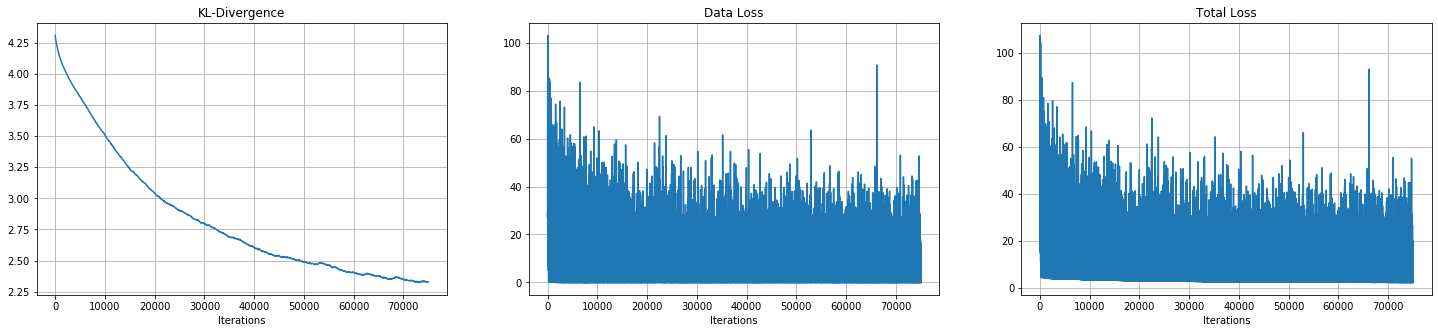

In [15]:
plt.clf()
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(train_kl)
plt.grid('on')
plt.title('KL-Divergence')
plt.xlabel('Iterations')
plt.subplot(132)
plt.plot(train_data)
plt.grid('on')
plt.title('Data Loss')
plt.xlabel('Iterations')
plt.subplot(133)
plt.plot(train_tot)
plt.grid('on')
plt.title('Total Loss')
plt.xlabel('Iterations')